<a href="https://colab.research.google.com/github/PierreBoissier/ssl_project/blob/main/SSL_for_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Si execution sur Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Définir le chemin vers ton fichier
data_path = '/content/drive/My Drive/data.tar.gz'

# Vérifier si le fichier existe
if os.path.exists(data_path):
    print("Fichier trouvé :", data_path)
else:
    print("Fichier introuvable. Vérifie le chemin.")

Fichier trouvé : /content/drive/My Drive/data.tar.gz


In [3]:
import tarfile

# Chemin où tu veux extraire les données
extract_path = '/content/data'

# Créer le dossier s'il n'existe pas
os.makedirs(extract_path, exist_ok=True)

# Extraire le fichier
with tarfile.open(data_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)
    print("Extraction terminée dans :", extract_path)

Extraction terminée dans : /content/data


Dans les dictionnaire de chemin il faut ajouter au debut /content/data/

# Self supervised learning for anomaly detection

# Librairy imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files  # Pour télécharger les modèles depuis Colab

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data exploration

In [7]:
class ImageDataExplorer:
    def __init__(self, data_dirs):
        """
        Initialise l'explorateur de données avec les chemins des répertoires des images.

        Args:
            data_dirs (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        """
        self.data_dirs = data_dirs
        self.transform = transforms.ToTensor()
        self.pixel_stats = {}

    def inspect_image_sizes(self, num_samples=10):
        """
        Inspecte les tailles d'images pour chaque catégorie.

        Args:
            num_samples (int): Nombre d'images à inspecter par catégorie.
        """
        for category, folder in self.data_dirs.items():
            image_sizes = []
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # (width, height)

            print(f"Exemples de tailles d'images pour {category} : {image_sizes}")
        print("\n")

    def compute_pixel_stats(self):
        """
        Calcule les moyennes et écarts-types des valeurs de pixels par canal (R, G, B).
        """
        pixel_sum = np.zeros(3)  # Pour la somme des pixels par canal (R, G, B)
        pixel_square_sum = np.zeros(3)  # Pour la somme des carrés des pixels par canal
        n_pixels = 0

        for category, folder in self.data_dirs.items():
            pixel_values = []
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    img_tensor = self.transform(img)
                    n_pixels += img_tensor.size(1) * img_tensor.size(2)  # Ajoute le nombre total de pixels par canal
                    pixel_sum += img_tensor.sum(dim=(1, 2)).numpy()  # Somme des pixels par canal
                    pixel_square_sum += (img_tensor ** 2).sum(dim=(1, 2)).numpy()  # Somme des carrés des pixels par canal

            # Moyenne et écart-type par canal
            mean = pixel_sum / n_pixels
            std = np.sqrt(pixel_square_sum / n_pixels - mean ** 2)

            # Stocker les statistiques dans le dictionnaire
            self.pixel_stats[category] = {"mean": mean, "std": std}

            print(f"Pour {category} :")
            print(f"Moyennes par canal (R, G, B) : {mean}")
            print(f"Écarts-types par canal (R, G, B) : {std}")
            print("\n")


    def get_pixel_stats(self):
        """
        Returns:
            dict: Dictionnaire contenant les moyennes et écarts-types par catégorie.
        """
        return self.pixel_stats


    def visualize_resized_images(self, img_sizes=(32, 64, 128, 256), num_samples=1):
        """
        Visualise les redimensionnements d'images à différentes tailles.

        Args:
            img_sizes (tuple): Tailles des redimensionnements à tester.
            num_samples (int): Nombre d'images à afficher par catégorie.
        """
        resize_transforms = {
            size: transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
            for size in img_sizes
        }

        for category, folder in self.data_dirs.items():
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    resized_images = {size: transform(img).permute(1, 2, 0) for size, transform in resize_transforms.items()}

                # Tracer les images redimensionnées
                fig, axs = plt.subplots(1, len(img_sizes), figsize=(15, 4))
                for ax, (size, resized_img) in zip(axs, resized_images.items()):
                    ax.imshow(resized_img)
                    ax.set_title(f"{size}x{size}")
                plt.suptitle(f"Redimensionnement des images de {category}")
                plt.show()


Exemples de tailles d'images pour bottle : [(900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900)]
Exemples de tailles d'images pour capsule : [(1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000)]
Exemples de tailles d'images pour hazelnut : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour toothbrush : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour engine_wiring : [(400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400)]


Pour bottle :
Moyennes par canal (R, G, B) : [0.53541012 0.53168199 0.54795864]
Écarts-types par canal (

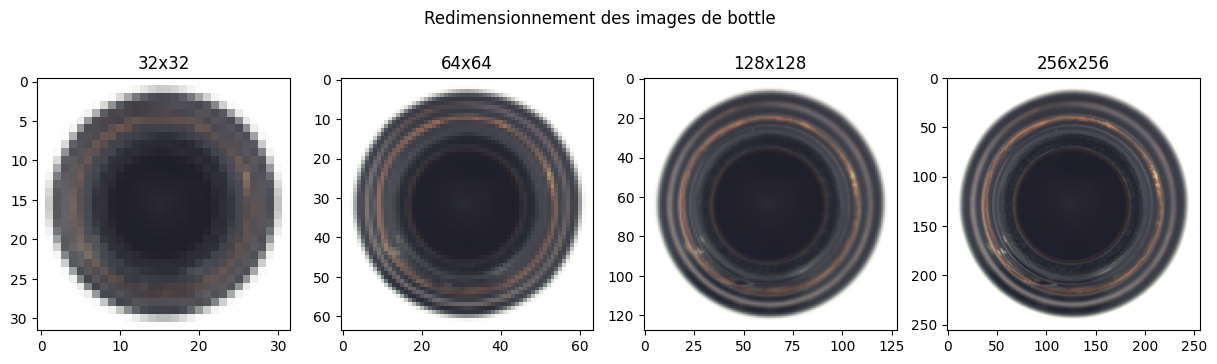

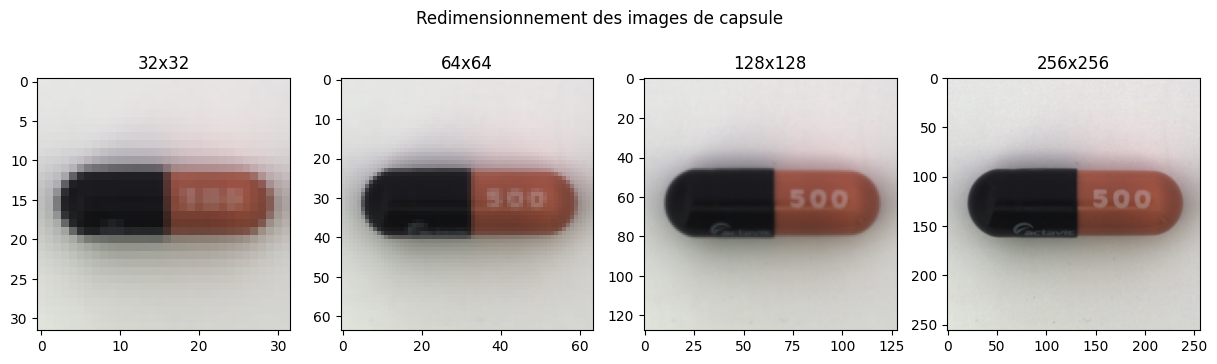

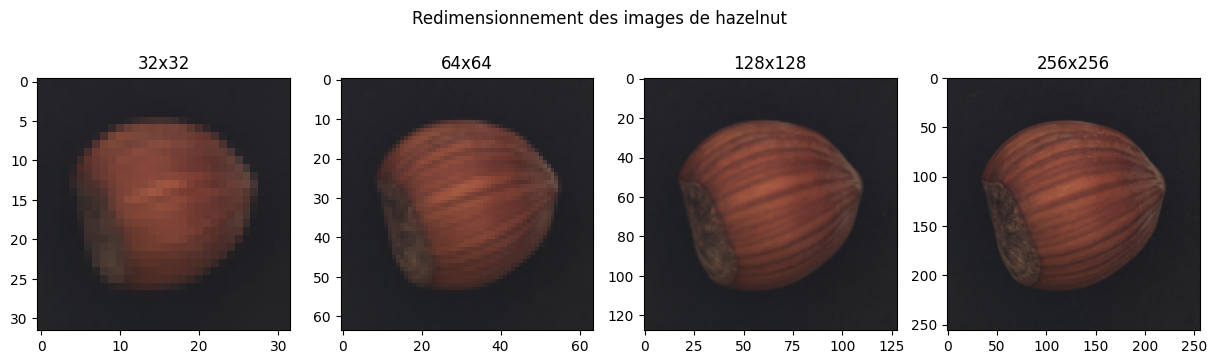

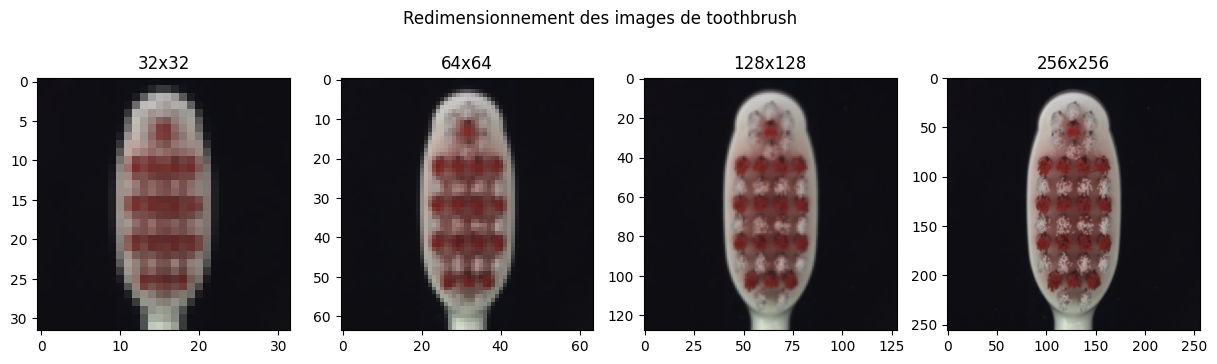

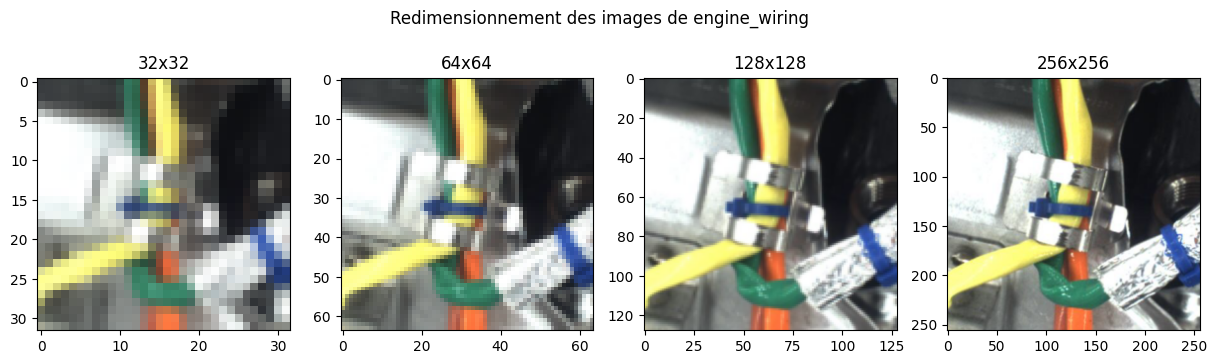

In [12]:
# Dossier racine des données
data_dir_dict = {
    'bottle': 'data/data/bottle/train/good',
    'capsule': 'data/data/capsule/train/good',
    'hazelnut': 'data/data/hazelnut/train/good',
    'toothbrush': 'data/data/toothbrush/train/good',
    'engine_wiring': 'data/data/engine_wiring/train/good'
}

explorer = ImageDataExplorer(data_dirs=data_dir_dict)

# Inspecter les tailles des images
explorer.inspect_image_sizes(num_samples=10)

# Calculer les statistiques des pixels
explorer.compute_pixel_stats()

# On stocke les statistiques des pixels pour la normalisation
pixel_stats = explorer.get_pixel_stats()

# Visualiser les différents redimensionnements
explorer.visualize_resized_images(img_sizes=(32, 64, 128, 256), num_samples=1)

# Data preparation

In [28]:
class CategoryDataset(Dataset):
    def __init__(self, root_dir, mean, std, mode="train"):
        """
        Classe pour charger un dataset d'une catégorie spécifique avec normalisation.

        Args:
            root_dir (str): Racine des données pour une catégorie spécifique.
            mean (list): Moyenne par canal (R, G, B).
            std (list): Écart-type par canal (R, G, B).
            mode (str): "train" ou "test".
        """
        self.root_dir = os.path.join(root_dir, mode)
        self.image_paths = []
        self.labels = []  # 0 = normal, 1 = anomalie

        # Transformation avec redimensionnement et normalisation
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # Charger les chemins d'images et les labels
        if mode == "train":
            normal_dir = os.path.join(self.root_dir, "good")
            self._add_images_from_dir(normal_dir, label=0)
        elif mode == "test":
            for defect_type in os.listdir(self.root_dir):
                defect_dir = os.path.join(self.root_dir, defect_type)
                label = 0 if defect_type == "good" else 1
                self._add_images_from_dir(defect_dir, label)

    def _add_images_from_dir(self, dir_path, label):
        """
        Ajoute les images d'un répertoire au dataset en filtrant les fichiers non valides.

        Args:
            dir_path (str): Chemin du répertoire contenant les images.
            label (int): Label associé aux images du répertoire.
        """
        if os.path.isdir(dir_path):
            for f in os.listdir(dir_path):
                file_path = os.path.join(dir_path, f)
                if os.path.isfile(file_path) and self._is_valid_image(file_path):
                    self.image_paths.append(file_path)
                    self.labels.append(label)

    @staticmethod
    def _is_valid_image(file_path):
        """
        Vérifie si un fichier est une image valide (en fonction de son extension).

        Args:
            file_path (str): Chemin du fichier.

        Returns:
            bool: True si le fichier est une image valide, False sinon.
        """
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        return file_path.lower().endswith(valid_extensions)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Erreur lors de l'ouverture de l'image : {image_path}\n{e}")

        if self.transform:
            image = self.transform(image)
        return image, label


In [29]:
def prepare_datasets(data_dir_dict, pixel_stats, mode="train"):
    """
    Crée les datasets pour chaque catégorie en utilisant les statistiques calculées.

    Args:
        data_dir_dict (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        pixel_stats (dict): Dictionnaire {catégorie: {"mean": [...], "std": [...]}}.
        mode (str): "train" ou "test".

    Returns:
        dict: Dictionnaire {catégorie: dataset}.
    """
    datasets_dict = {}

    for category, folder in data_dir_dict.items():
        mean = pixel_stats[category]["mean"]
        std = pixel_stats[category]["std"]

        # Créer le dataset pour la catégorie
        datasets_dict[category] = CategoryDataset(
            root_dir=folder,
            mean=mean,
            std=std,
            mode=mode
        )

    return datasets_dict


In [30]:
# On verifie qu'on a bien nos stats

print("Statistiques des pixels :")
for category, stats in pixel_stats.items():
    print(f"{category} : Moyenne = {stats['mean']}, Écart-type = {stats['std']}")


Statistiques des pixels :
bottle : Moyenne = [0.53541012 0.53168199 0.54795864], Écart-type = [0.36676049 0.36667316 0.34991978]
capsule : Moyenne = [0.62641897 0.60788297 0.6077917 ], Écart-type = [0.31168132 0.31775514 0.30712102]
hazelnut : Moyenne = [0.42798804 0.3865043  0.38363421], Écart-type = [0.31494227 0.31383207 0.30733228]
toothbrush : Moyenne = [0.41128353 0.37180342 0.36970357], Écart-type = [0.31515439 0.31211631 0.30463895]
engine_wiring : Moyenne = [0.4155514  0.37774341 0.3734649 ], Écart-type = [0.31693172 0.31385003 0.3048015 ]


In [31]:
data_dir_dict = {
    'bottle': 'data/data/bottle',
    'capsule': 'data/data/capsule',
    'hazelnut': 'data/data/hazelnut',
    'toothbrush': 'data/data/toothbrush',
    'engine_wiring': 'data/data/engine_wiring'
}

# Créer les datasets
train_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="train")
test_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="test")

# Vérification
print(f"Datasets de train créés pour les catégories : {list(train_datasets_dict.keys())}")
print(f"Datasets de test créés pour les catégories : {list(test_datasets_dict.keys())}")


Datasets de train créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']
Datasets de test créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']


In [32]:
batch_size = 32

# On crée les loaders

train_bottle_loader = DataLoader(train_datasets_dict['bottle'], batch_size=batch_size, shuffle=True)
test_bottle_loader = DataLoader(test_datasets_dict['bottle'], batch_size=batch_size, shuffle=False)

train_capsule_loader = DataLoader(train_datasets_dict['capsule'], batch_size=batch_size, shuffle=True)
test_capsule_loader = DataLoader(test_datasets_dict['capsule'], batch_size=batch_size, shuffle=False)

train_hazelnut_loader = DataLoader(train_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=True)
test_hazelnut_loader = DataLoader(test_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=False)

train_toothbrush_loader = DataLoader(train_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=True)
test_toothbrush_loader = DataLoader(test_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=False)

train_engine_wiring_loader = DataLoader(train_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=True)
test_engine_wiring_loader = DataLoader(test_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=False)


# On vérifie un batch
images, labels = next(iter(test_bottle_loader))
print(f"Taille du batch : {images.shape}, Labels : {labels}")


Taille du batch : torch.Size([32, 3, 256, 256]), Labels : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [33]:
# On vérifie qu'on a bien les données good et défectueuses dans les test_loader
total_good = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 0)
total_defective = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 1)
print(f"Total images normales : {total_good}, Total images défectueuses : {total_defective}")


Total images normales : 285, Total images défectueuses : 322


In [34]:
# Dictionnaire des DataLoaders existants
data_loaders_dict = {
    'bottle': {
        'train_loader': train_bottle_loader,
        'test_loader': test_bottle_loader
    },
    'capsule': {
        'train_loader': train_capsule_loader,
        'test_loader': test_capsule_loader
    },
    'hazelnut': {
        'train_loader': train_hazelnut_loader,
        'test_loader': test_hazelnut_loader
    },
    'toothbrush': {
        'train_loader': train_toothbrush_loader,
        'test_loader': test_toothbrush_loader
    },
    'engine_wiring': {
        'train_loader': train_engine_wiring_loader,
        'test_loader': test_engine_wiring_loader
    }
}

# On reproduit le TP SSL sur nos données comme premier test

## Architecture partagée

In [35]:
# Encoder architecture
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.encoder(x)



# Decoder architecture
class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=128):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.decoder(x)

## Fonction d'entrainement

In [36]:
def train_ssl_model(model, train_loader, test_loader, criterion, optimizer, device=device, epochs=10):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0
        #t=tqdm(train_loader)
        for images, _ in train_loader: #t
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    # Tracer les pertes d'entraînement et de validation
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model.encoder

## Fonction d'evaluation

In [37]:
def evaluate_ssl_model(model, test_loader, criterion=nn.MSELoss(reduction="none"), device="cuda"):
    """
    Évalue un modèle SSL sur les données de test et retourne l'AUROC.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        test_loader (DataLoader): DataLoader pour les données de test.
        criterion (callable): Fonction de perte utilisée pour calculer le score d'anomalie.
        device (str): Périphérique pour l'évaluation.

    Returns:
        float: AUROC pour le modèle sur les données de test.
    """
    model.to(device)
    model.eval()

    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Calcul de la sortie du modèle
            outputs, _ = model(images)

            # Calcul de la perte entre l'image reconstruite et l'image originale
            loss = criterion(outputs, images)  # Perte par pixel
            per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image

            anomaly_scores.extend(per_image_loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calcul des métriques ROC
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Traçage de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc



## Pretext : Colorization

In [38]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

## Pretext : Inpainting

In [39]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=64):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked

    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

## Pretext : Masked Autoencoder

In [40]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=128, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

## Pipeline d'entrainement et d'evaluation

In [43]:
def run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"],
                                   num_epochs=10, latent_dim=128, device=device):
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "inpainting":
                model = InpaintingModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()

            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Entraîner le modèle
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]
            train_ssl_model(model, train_loader, test_loader, criterion, optimizer,
                                       device=device, epochs=num_epochs)

            # Sauvegarder le modèle
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Télécharger le modèle sur Colab
            try:
                files.download(model_path)
            except Exception as e:
                print(f"Erreur lors du téléchargement : {e}")


            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(model, test_loader, device=device)

            # Stocker les résultats
            category_results[pretext] = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results



=== Entraînement pour la catégorie bottle ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.8501, Avg Val Loss: 0.6331
Epoch 2/10, Train Loss: 0.6375, Avg Val Loss: 0.6033
Epoch 3/10, Train Loss: 0.6069, Avg Val Loss: 0.5674
Epoch 4/10, Train Loss: 0.5651, Avg Val Loss: 0.5265
Epoch 5/10, Train Loss: 0.5276, Avg Val Loss: 0.4808
Epoch 6/10, Train Loss: 0.4733, Avg Val Loss: 0.4373
Epoch 7/10, Train Loss: 0.4420, Avg Val Loss: 0.4107
Epoch 8/10, Train Loss: 0.4207, Avg Val Loss: 0.3993
Epoch 9/10, Train Loss: 0.4143, Avg Val Loss: 0.3957
Epoch 10/10, Train Loss: 0.4110, Avg Val Loss: 0.3935


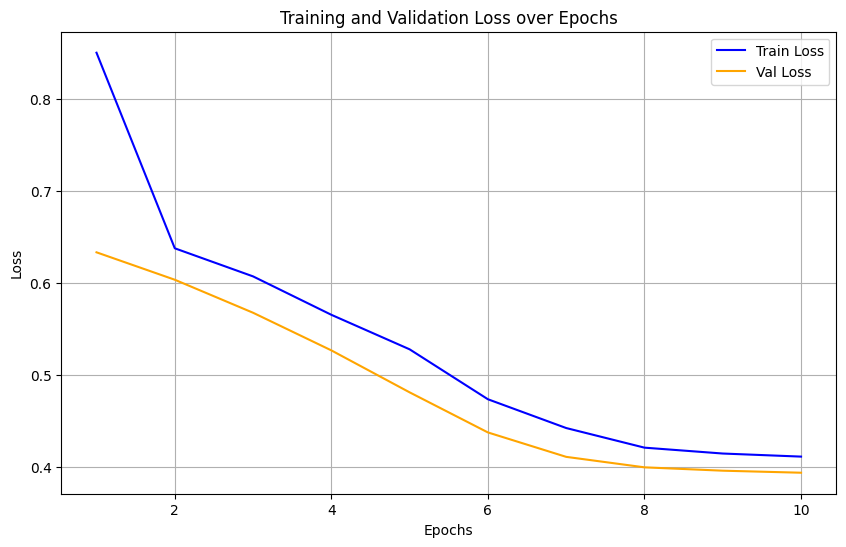

Modèle sauvegardé : bottle_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie bottle ===


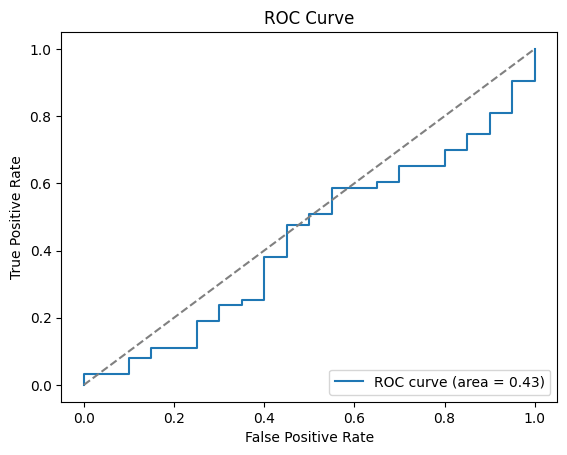

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8369, Avg Val Loss: 0.6757
Epoch 2/10, Train Loss: 0.6243, Avg Val Loss: 0.5219
Epoch 3/10, Train Loss: 0.5216, Avg Val Loss: 0.4864
Epoch 4/10, Train Loss: 0.4902, Avg Val Loss: 0.4576
Epoch 5/10, Train Loss: 0.4633, Avg Val Loss: 0.4379
Epoch 6/10, Train Loss: 0.4487, Avg Val Loss: 0.4287
Epoch 7/10, Train Loss: 0.4410, Avg Val Loss: 0.4191
Epoch 8/10, Train Loss: 0.4345, Avg Val Loss: 0.4145
Epoch 9/10, Train Loss: 0.4326, Avg Val Loss: 0.4126
Epoch 10/10, Train Loss: 0.4295, Avg Val Loss: 0.4145


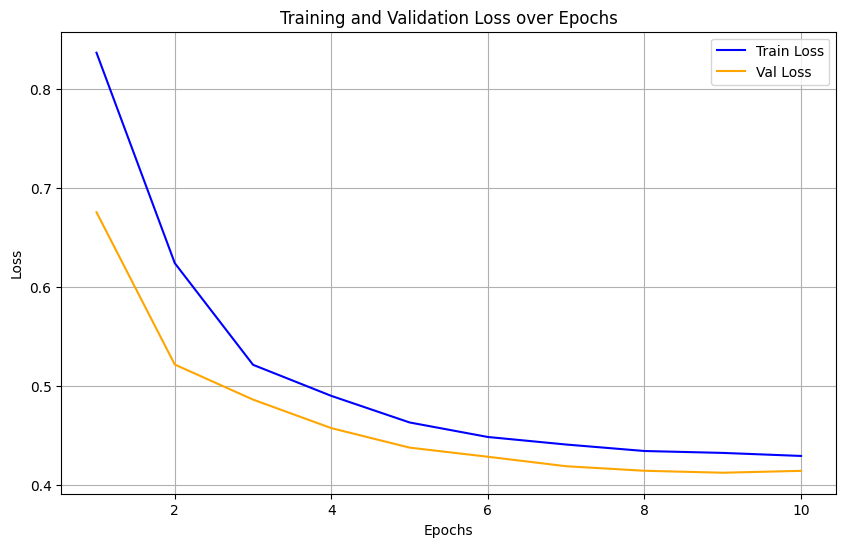

Modèle sauvegardé : bottle_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie bottle ===


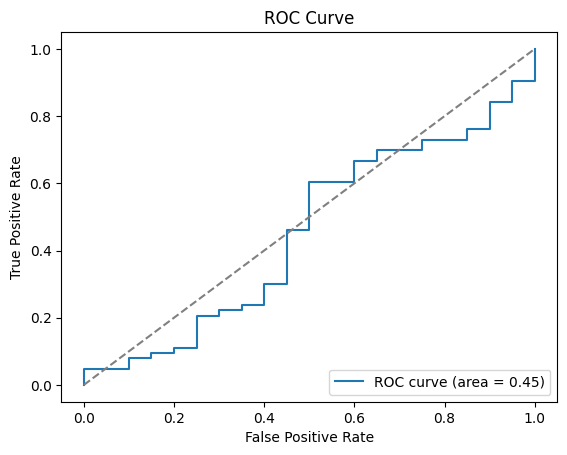

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 2/10, Train Loss: 0.9957, Avg Val Loss: 0.9791
Epoch 3/10, Train Loss: 0.9951, Avg Val Loss: 0.9791
Epoch 4/10, Train Loss: 0.9955, Avg Val Loss: 0.9791
Epoch 5/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 6/10, Train Loss: 0.9952, Avg Val Loss: 0.9791
Epoch 7/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 8/10, Train Loss: 0.9955, Avg Val Loss: 0.9791
Epoch 9/10, Train Loss: 0.9956, Avg Val Loss: 0.9791
Epoch 10/10, Train Loss: 0.9954, Avg Val Loss: 0.9791


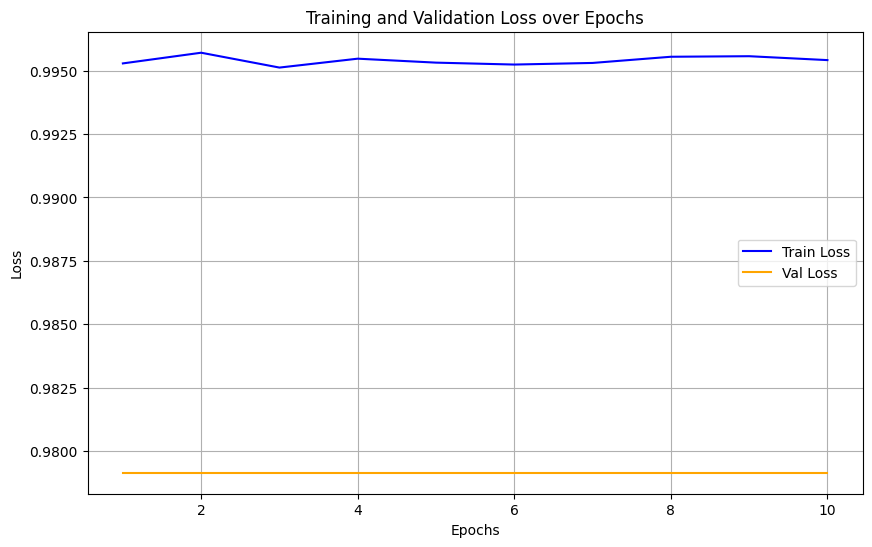

Modèle sauvegardé : bottle_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie bottle ===


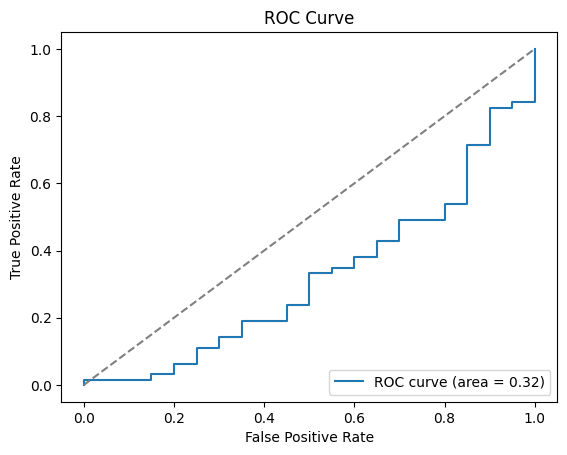

=== Entraînement pour la catégorie capsule ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.6047, Avg Val Loss: 0.4751
Epoch 2/10, Train Loss: 0.4618, Avg Val Loss: 0.4367
Epoch 3/10, Train Loss: 0.4394, Avg Val Loss: 0.4302
Epoch 4/10, Train Loss: 0.4328, Avg Val Loss: 0.4236
Epoch 5/10, Train Loss: 0.4252, Avg Val Loss: 0.4115
Epoch 6/10, Train Loss: 0.4088, Avg Val Loss: 0.3987
Epoch 7/10, Train Loss: 0.4030, Avg Val Loss: 0.3973
Epoch 8/10, Train Loss: 0.4011, Avg Val Loss: 0.3954
Epoch 9/10, Train Loss: 0.3996, Avg Val Loss: 0.3948
Epoch 10/10, Train Loss: 0.3985, Avg Val Loss: 0.3902


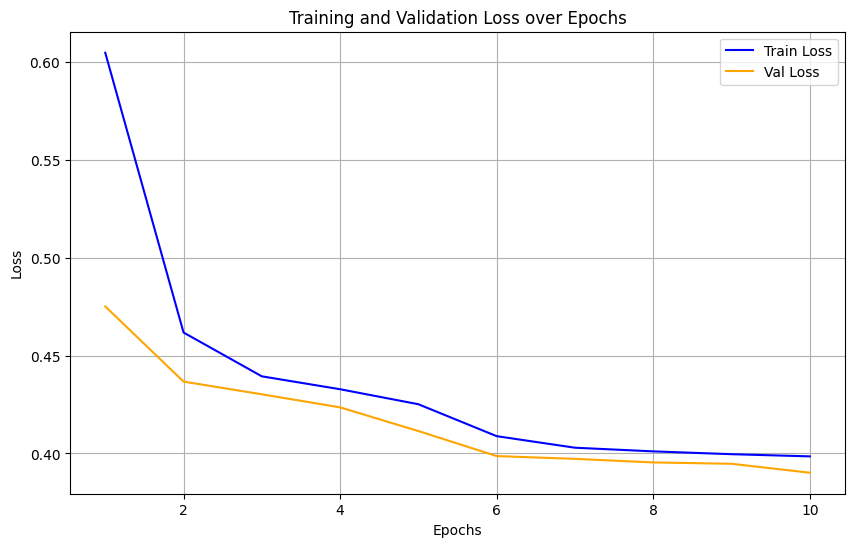

Modèle sauvegardé : capsule_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie capsule ===


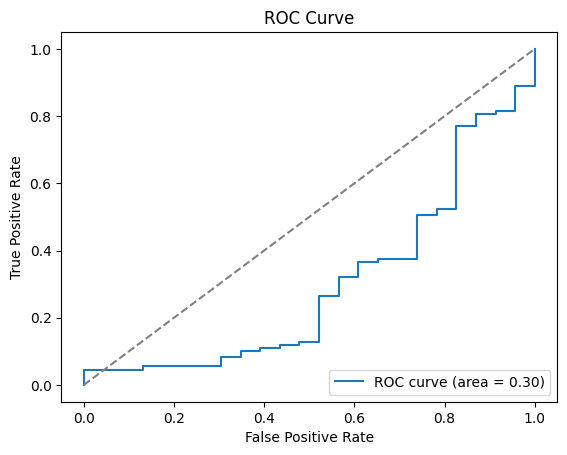

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.6436, Avg Val Loss: 0.5644
Epoch 2/10, Train Loss: 0.5798, Avg Val Loss: 0.5509
Epoch 3/10, Train Loss: 0.5411, Avg Val Loss: 0.5185
Epoch 4/10, Train Loss: 0.5162, Avg Val Loss: 0.5009
Epoch 5/10, Train Loss: 0.4968, Avg Val Loss: 0.4838
Epoch 6/10, Train Loss: 0.4795, Avg Val Loss: 0.4631
Epoch 7/10, Train Loss: 0.4576, Avg Val Loss: 0.4408
Epoch 8/10, Train Loss: 0.4405, Avg Val Loss: 0.4285
Epoch 9/10, Train Loss: 0.4306, Avg Val Loss: 0.4243
Epoch 10/10, Train Loss: 0.4183, Avg Val Loss: 0.3982


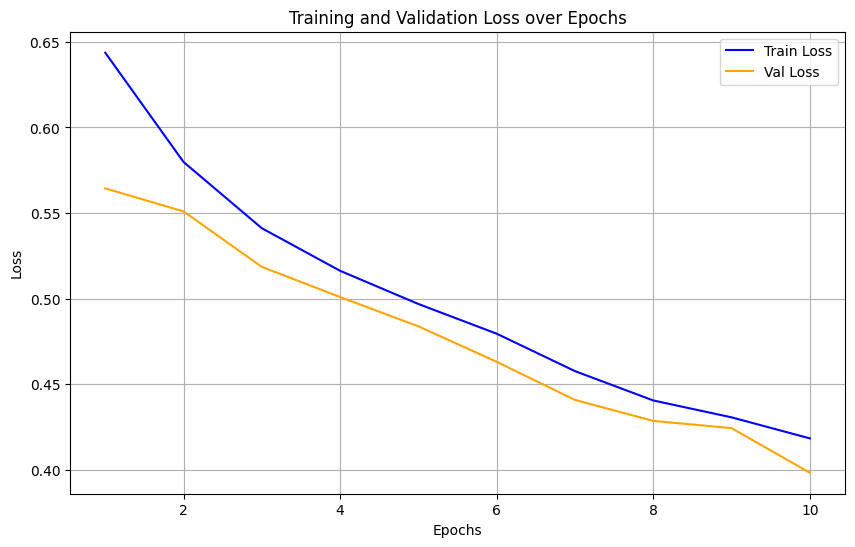

Modèle sauvegardé : capsule_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie capsule ===


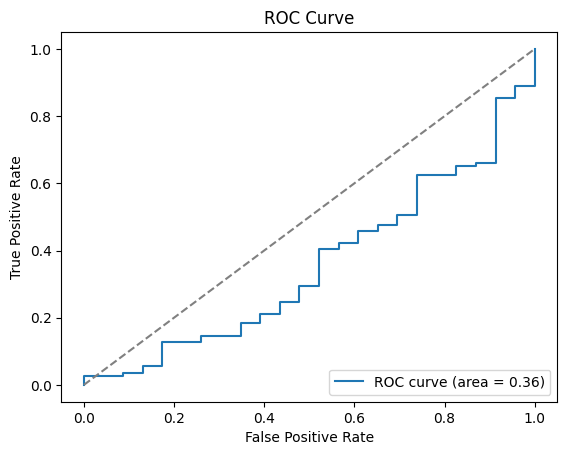

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 2/10, Train Loss: 0.6905, Avg Val Loss: 0.6831
Epoch 3/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 4/10, Train Loss: 0.6897, Avg Val Loss: 0.6831
Epoch 5/10, Train Loss: 0.6898, Avg Val Loss: 0.6831
Epoch 6/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 7/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 8/10, Train Loss: 0.6902, Avg Val Loss: 0.6831
Epoch 9/10, Train Loss: 0.6902, Avg Val Loss: 0.6831
Epoch 10/10, Train Loss: 0.6899, Avg Val Loss: 0.6831


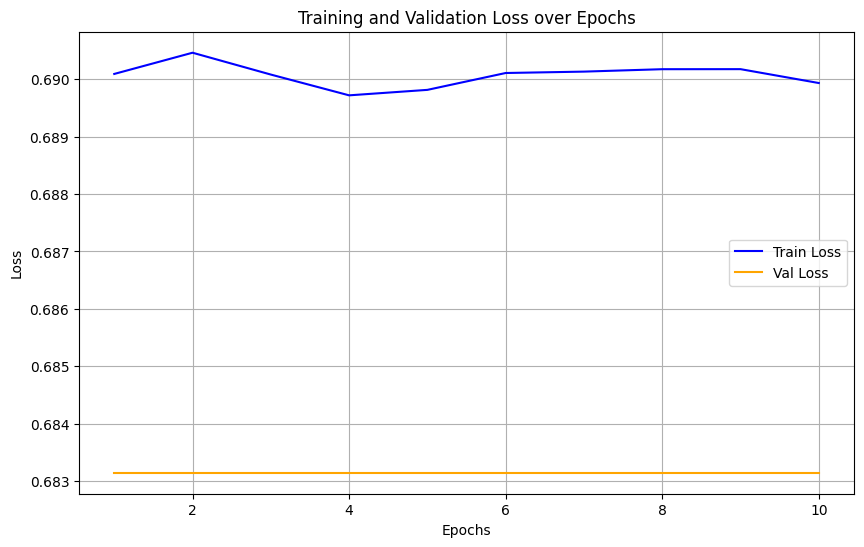

Modèle sauvegardé : capsule_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie capsule ===


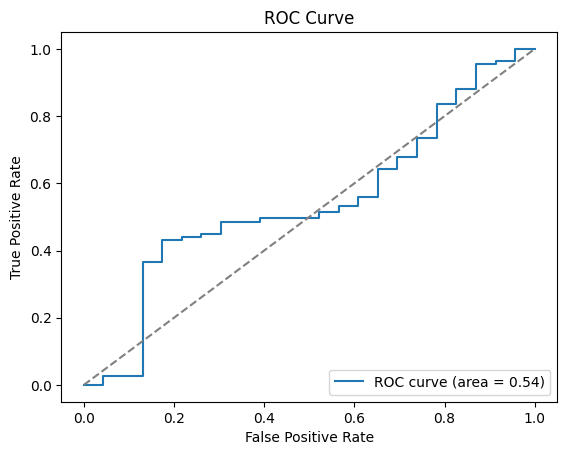

=== Entraînement pour la catégorie hazelnut ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.5470, Avg Val Loss: 0.4956
Epoch 2/10, Train Loss: 0.5471, Avg Val Loss: 0.4956
Epoch 3/10, Train Loss: 0.5445, Avg Val Loss: 0.4956
Epoch 4/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 5/10, Train Loss: 0.5468, Avg Val Loss: 0.4956
Epoch 6/10, Train Loss: 0.5472, Avg Val Loss: 0.4956
Epoch 7/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 8/10, Train Loss: 0.5467, Avg Val Loss: 0.4956
Epoch 9/10, Train Loss: 0.5471, Avg Val Loss: 0.4956
Epoch 10/10, Train Loss: 0.5479, Avg Val Loss: 0.4956


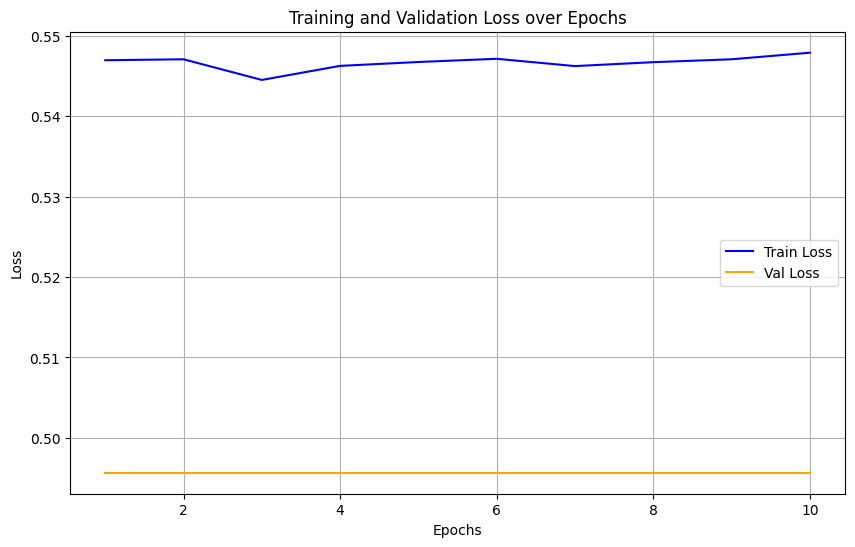

Modèle sauvegardé : hazelnut_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie hazelnut ===


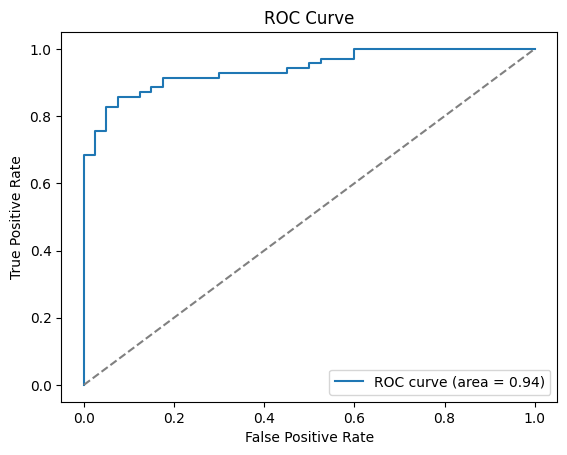

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.5575, Avg Val Loss: 0.4950
Epoch 2/10, Train Loss: 0.5442, Avg Val Loss: 0.4876
Epoch 3/10, Train Loss: 0.5363, Avg Val Loss: 0.4861
Epoch 4/10, Train Loss: 0.5370, Avg Val Loss: 0.4860
Epoch 5/10, Train Loss: 0.5364, Avg Val Loss: 0.4860
Epoch 6/10, Train Loss: 0.5342, Avg Val Loss: 0.4861
Epoch 7/10, Train Loss: 0.5356, Avg Val Loss: 0.4860
Epoch 8/10, Train Loss: 0.5371, Avg Val Loss: 0.4862
Epoch 9/10, Train Loss: 0.5348, Avg Val Loss: 0.4859
Epoch 10/10, Train Loss: 0.5356, Avg Val Loss: 0.4869


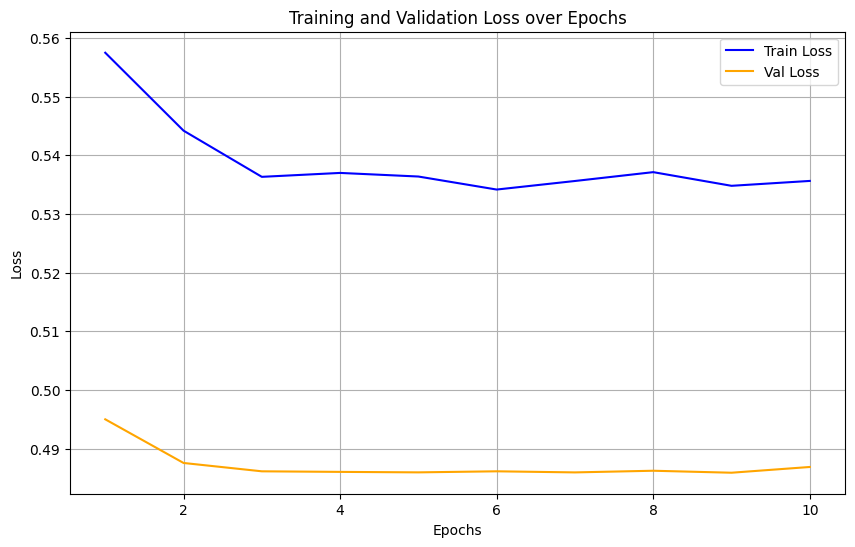

Modèle sauvegardé : hazelnut_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie hazelnut ===


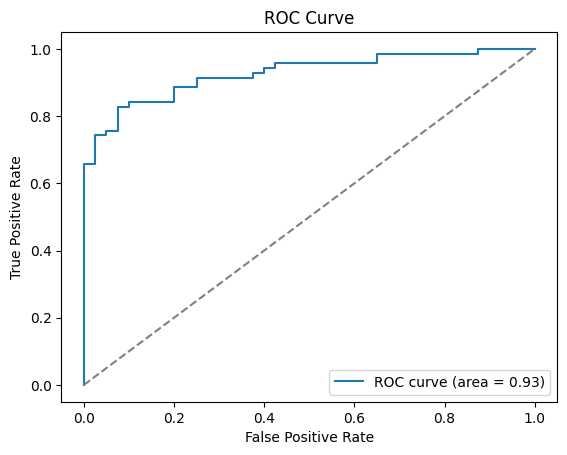

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.5478, Avg Val Loss: 0.4957
Epoch 2/10, Train Loss: 0.5459, Avg Val Loss: 0.4956
Epoch 3/10, Train Loss: 0.5476, Avg Val Loss: 0.4956
Epoch 4/10, Train Loss: 0.5470, Avg Val Loss: 0.4956
Epoch 5/10, Train Loss: 0.5469, Avg Val Loss: 0.4956
Epoch 6/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 7/10, Train Loss: 0.5477, Avg Val Loss: 0.4956
Epoch 8/10, Train Loss: 0.5483, Avg Val Loss: 0.4956
Epoch 9/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 10/10, Train Loss: 0.5455, Avg Val Loss: 0.4956


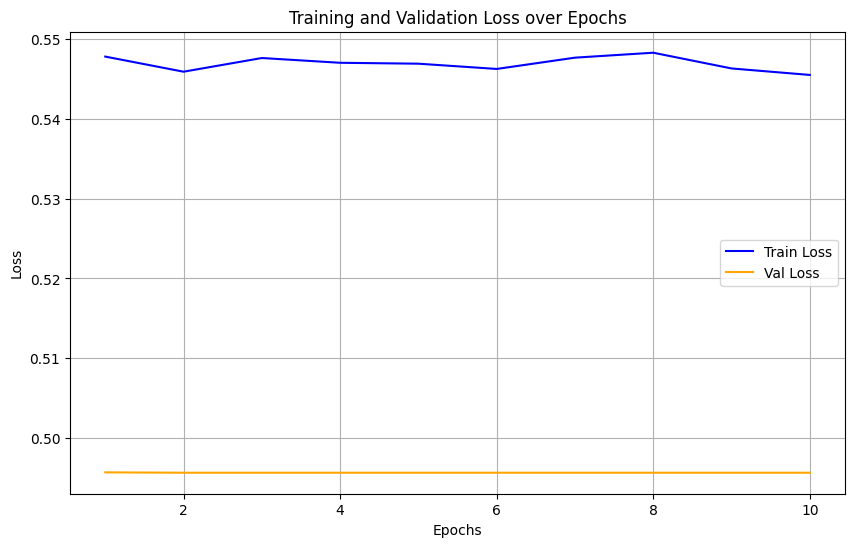

Modèle sauvegardé : hazelnut_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie hazelnut ===


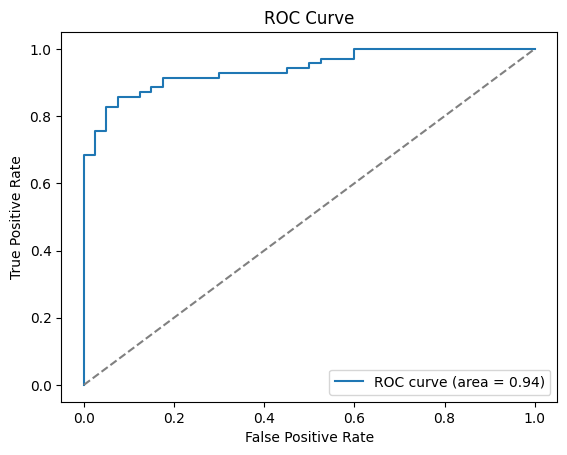

=== Entraînement pour la catégorie toothbrush ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.8485, Avg Val Loss: 0.8413
Epoch 2/10, Train Loss: 0.8490, Avg Val Loss: 0.8413
Epoch 3/10, Train Loss: 0.8487, Avg Val Loss: 0.8413
Epoch 4/10, Train Loss: 0.8486, Avg Val Loss: 0.8413
Epoch 5/10, Train Loss: 0.8488, Avg Val Loss: 0.8413
Epoch 6/10, Train Loss: 0.8484, Avg Val Loss: 0.8413
Epoch 7/10, Train Loss: 0.8481, Avg Val Loss: 0.8413
Epoch 8/10, Train Loss: 0.8486, Avg Val Loss: 0.8413
Epoch 9/10, Train Loss: 0.8484, Avg Val Loss: 0.8413
Epoch 10/10, Train Loss: 0.8487, Avg Val Loss: 0.8413


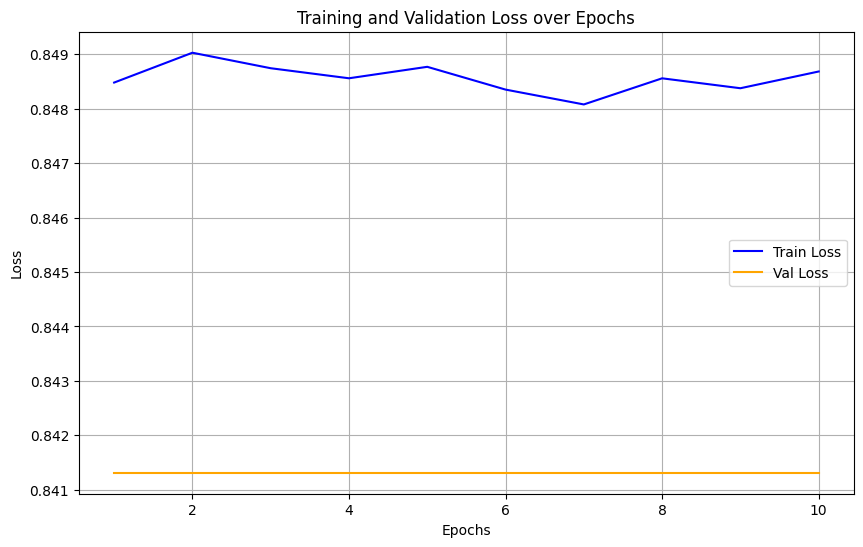

Modèle sauvegardé : toothbrush_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie toothbrush ===


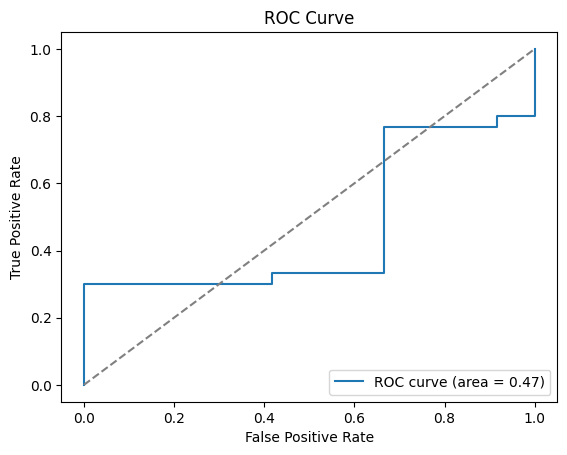

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8492, Avg Val Loss: 0.8401
Epoch 2/10, Train Loss: 0.8442, Avg Val Loss: 0.8312
Epoch 3/10, Train Loss: 0.8331, Avg Val Loss: 0.8168
Epoch 4/10, Train Loss: 0.8204, Avg Val Loss: 0.8098
Epoch 5/10, Train Loss: 0.8133, Avg Val Loss: 0.8026
Epoch 6/10, Train Loss: 0.8062, Avg Val Loss: 0.8012
Epoch 7/10, Train Loss: 0.8031, Avg Val Loss: 0.7952
Epoch 8/10, Train Loss: 0.7988, Avg Val Loss: 0.7926
Epoch 9/10, Train Loss: 0.7954, Avg Val Loss: 0.7889
Epoch 10/10, Train Loss: 0.7923, Avg Val Loss: 0.7838


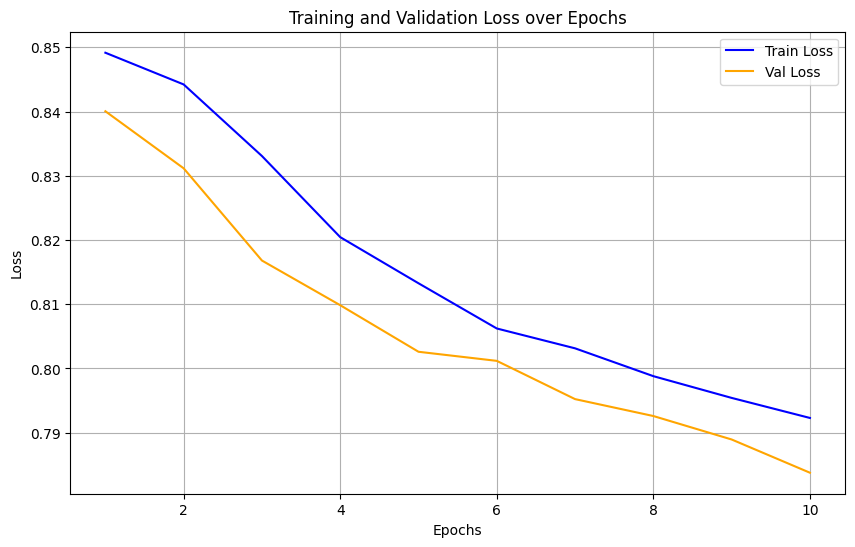

Modèle sauvegardé : toothbrush_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie toothbrush ===


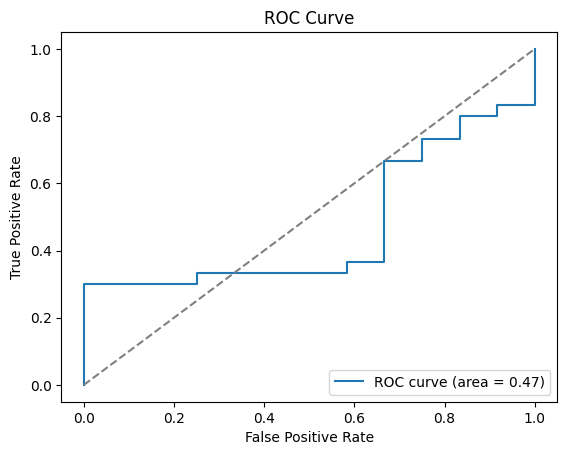

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.8768, Avg Val Loss: 0.8552
Epoch 2/10, Train Loss: 0.8544, Avg Val Loss: 0.8376
Epoch 3/10, Train Loss: 0.8445, Avg Val Loss: 0.8362
Epoch 4/10, Train Loss: 0.8430, Avg Val Loss: 0.8321
Epoch 5/10, Train Loss: 0.8375, Avg Val Loss: 0.8220
Epoch 6/10, Train Loss: 0.8274, Avg Val Loss: 0.8140
Epoch 7/10, Train Loss: 0.8175, Avg Val Loss: 0.8078
Epoch 8/10, Train Loss: 0.8105, Avg Val Loss: 0.8031
Epoch 9/10, Train Loss: 0.8051, Avg Val Loss: 0.7965
Epoch 10/10, Train Loss: 0.7978, Avg Val Loss: 0.7913


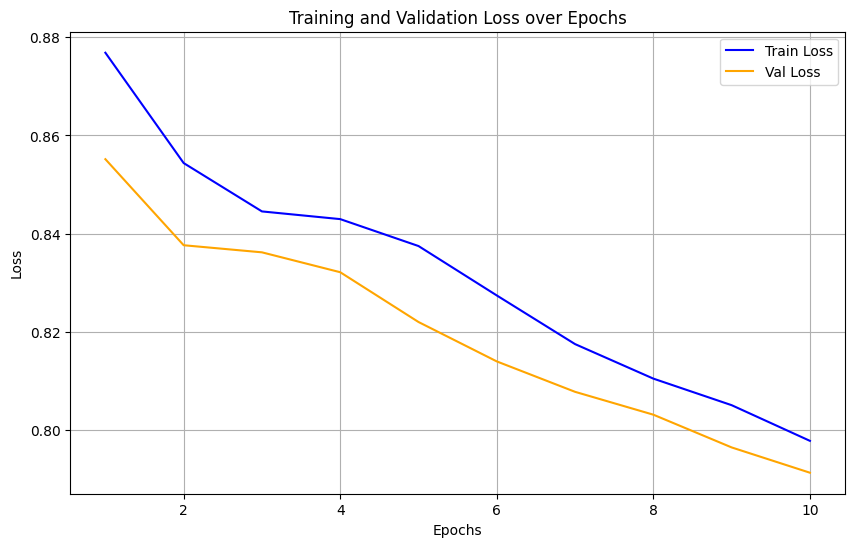

Modèle sauvegardé : toothbrush_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie toothbrush ===


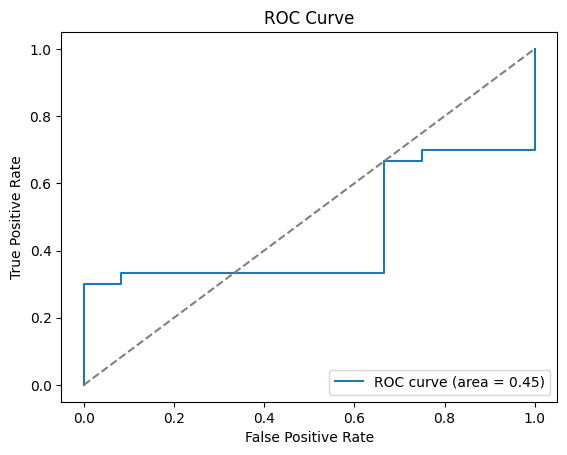

=== Entraînement pour la catégorie engine_wiring ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.9471, Avg Val Loss: 0.8931
Epoch 2/10, Train Loss: 0.7967, Avg Val Loss: 0.6810
Epoch 3/10, Train Loss: 0.5511, Avg Val Loss: 0.4896
Epoch 4/10, Train Loss: 0.4566, Avg Val Loss: 0.4281
Epoch 5/10, Train Loss: 0.4075, Avg Val Loss: 0.4005
Epoch 6/10, Train Loss: 0.3859, Avg Val Loss: 0.3836
Epoch 7/10, Train Loss: 0.3731, Avg Val Loss: 0.3743
Epoch 8/10, Train Loss: 0.3638, Avg Val Loss: 0.3651
Epoch 9/10, Train Loss: 0.3567, Avg Val Loss: 0.3603
Epoch 10/10, Train Loss: 0.3519, Avg Val Loss: 0.3566


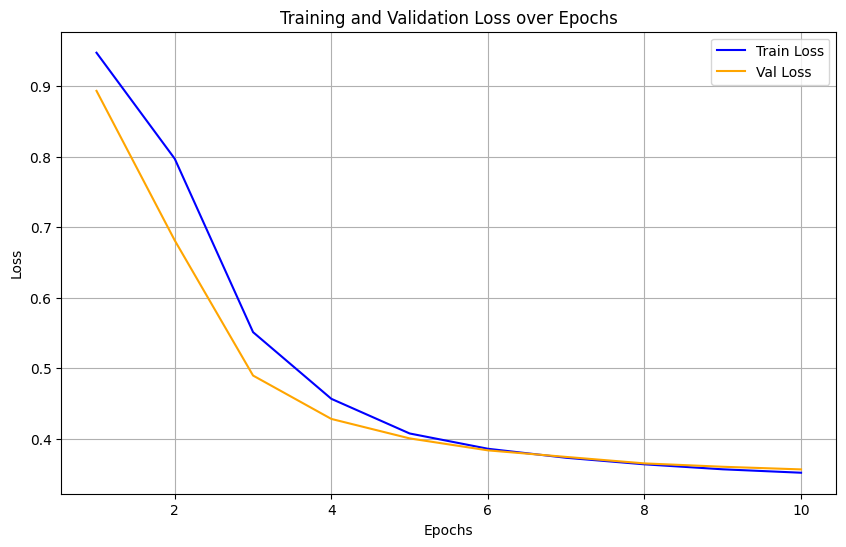

Modèle sauvegardé : engine_wiring_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie engine_wiring ===


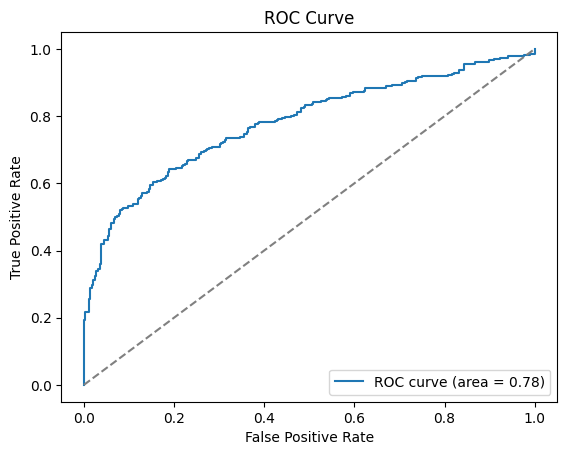

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8780, Avg Val Loss: 0.8012
Epoch 2/10, Train Loss: 0.6323, Avg Val Loss: 0.5121
Epoch 3/10, Train Loss: 0.4820, Avg Val Loss: 0.4639
Epoch 4/10, Train Loss: 0.4429, Avg Val Loss: 0.4343
Epoch 5/10, Train Loss: 0.4170, Avg Val Loss: 0.4081
Epoch 6/10, Train Loss: 0.3952, Avg Val Loss: 0.3900
Epoch 7/10, Train Loss: 0.3766, Avg Val Loss: 0.3640
Epoch 8/10, Train Loss: 0.3467, Avg Val Loss: 0.3494
Epoch 9/10, Train Loss: 0.3355, Avg Val Loss: 0.3352
Epoch 10/10, Train Loss: 0.3236, Avg Val Loss: 0.3243


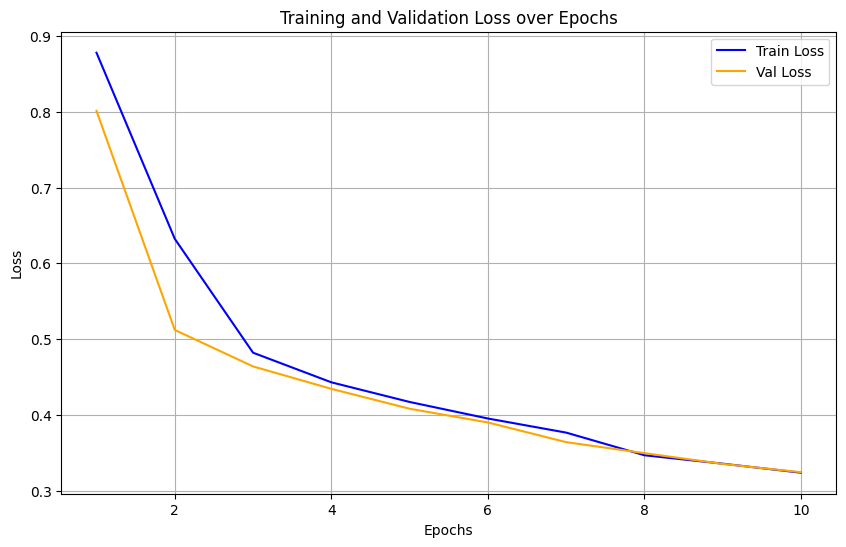

Modèle sauvegardé : engine_wiring_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie engine_wiring ===


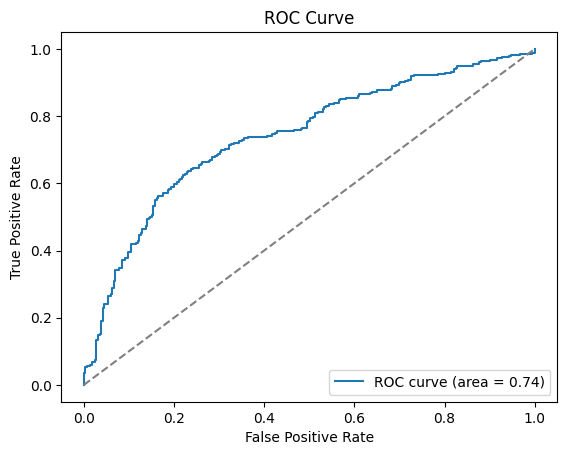

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.9418, Avg Val Loss: 0.7062
Epoch 2/10, Train Loss: 0.6123, Avg Val Loss: 0.5043
Epoch 3/10, Train Loss: 0.4565, Avg Val Loss: 0.4187
Epoch 4/10, Train Loss: 0.3903, Avg Val Loss: 0.3772
Epoch 5/10, Train Loss: 0.3567, Avg Val Loss: 0.3427
Epoch 6/10, Train Loss: 0.3208, Avg Val Loss: 0.3140
Epoch 7/10, Train Loss: 0.3051, Avg Val Loss: 0.3046
Epoch 8/10, Train Loss: 0.2963, Avg Val Loss: 0.2990
Epoch 9/10, Train Loss: 0.2890, Avg Val Loss: 0.2932
Epoch 10/10, Train Loss: 0.2834, Avg Val Loss: 0.2886


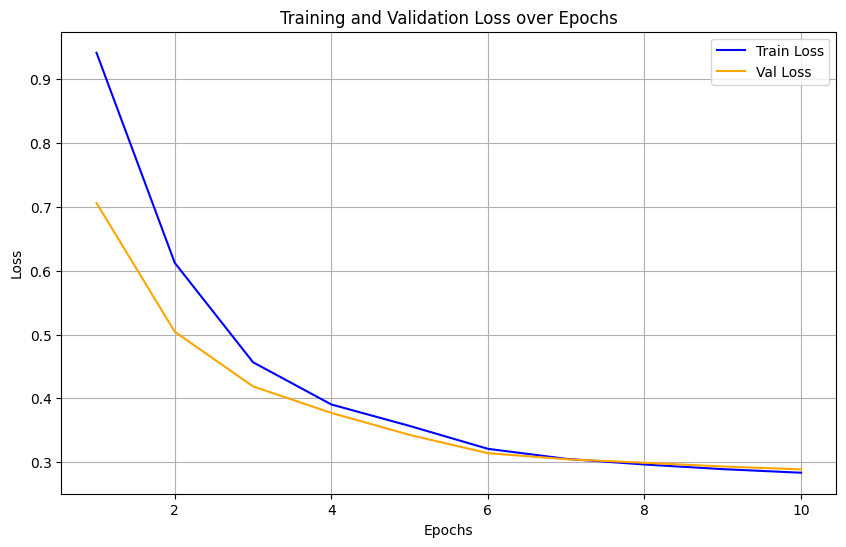

Modèle sauvegardé : engine_wiring_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie engine_wiring ===


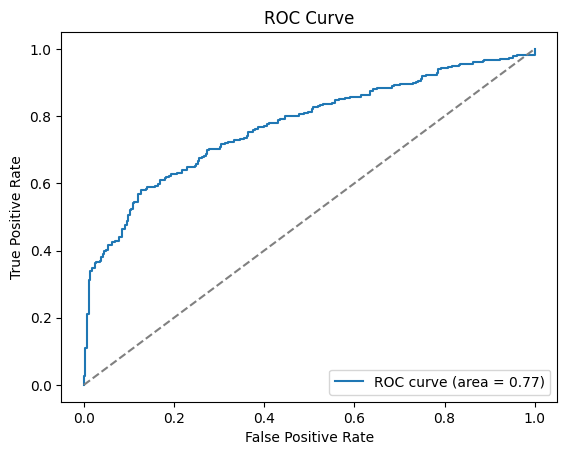

bottle - colorization: AUROC = 0.43
bottle - inpainting: AUROC = 0.45
bottle - maskedautoencoder: AUROC = 0.32
capsule - colorization: AUROC = 0.30
capsule - inpainting: AUROC = 0.36
capsule - maskedautoencoder: AUROC = 0.54
hazelnut - colorization: AUROC = 0.94
hazelnut - inpainting: AUROC = 0.93
hazelnut - maskedautoencoder: AUROC = 0.94
toothbrush - colorization: AUROC = 0.47
toothbrush - inpainting: AUROC = 0.47
toothbrush - maskedautoencoder: AUROC = 0.45
engine_wiring - colorization: AUROC = 0.78
engine_wiring - inpainting: AUROC = 0.74
engine_wiring - maskedautoencoder: AUROC = 0.77


In [44]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], num_epochs=10)

# Afficher les résultats
for category, pretext_results in results.items():
    for pretext, result in pretext_results.items():
        print(f"{category} - {pretext}: AUROC = {result['roc_auc']:.2f}")


# On affiche les anomalies pour faire un model adpaté à chaque catégorie d'image

In [ ]:
import torch.nn.functional as F

def calculate_mse(img1, img2):
    """
    Calcule la Mean Squared Error (MSE) entre deux images en utilisant PyTorch.

    Args:
        img1 (PIL.Image): Première image.
        img2 (PIL.Image): Deuxième image.

    Returns:
        float: La MSE entre les deux images.
    """
    img1 = torch.tensor(np.array(img1).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch
    img2 = torch.tensor(np.array(img2).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch

    loss = F.mse_loss(img1, img2, reduction='none')  # Perte par pixel
    per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image
    return per_image_loss.item()

def display_anomalies(data_dir):
    """
    Affiche une image pour chaque type d'anomalie dans les données de test et calcule la MSE entre une image "good" et une image d'anomalie.

    Args:
        data_dir (str): Chemin racine du dataset (e.g., "data/").
    """
    categories = os.listdir(data_dir)  # Liste des catégories (e.g., "bottle", "capsule")

    for category in categories:
        category_path = os.path.join(data_dir, category, "test")
        good_path = os.path.join(data_dir, category, "train", "good")
        if not os.path.exists(category_path) or not os.path.exists(good_path):
            continue  # Ignorer si le dossier n'existe pas

        print(f"Catégorie : {category}")
        anomaly_types = [d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d))]

        # Charger une image "good"
        good_images = [os.path.join(good_path, img) for img in os.listdir(good_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        if not good_images:
            print(f"  Aucun fichier 'good' trouvé pour la catégorie : {category}")
            continue
        good_image = Image.open(good_images[0])

        fig, axs = plt.subplots(1, len(anomaly_types), figsize=(15, 5))
        if len(anomaly_types) == 1:
            axs = [axs]  # Si une seule anomalie, convertir en liste

        for ax, anomaly in zip(axs, anomaly_types):
            anomaly_path = os.path.join(category_path, anomaly)
            images = os.listdir(anomaly_path)

            if not images:
                print(f"  Aucun fichier pour l'anomalie : {anomaly}")
                continue

            # Charger jusqu'à 5 images d'anomalie
            anomaly_images = [os.path.join(anomaly_path, img) for img in images[:5]]
            mse_values = []

            for img_path in anomaly_images:
                with Image.open(img_path) as img:
                    mse = calculate_mse(good_image, img)
                    mse_values.append(mse)

            avg_mse = np.mean(mse_values)
            print(f"  MSE moyenne pour l'anomalie {anomaly} : {avg_mse:.2f}")

            # Afficher la première image d'anomalie
            with Image.open(anomaly_images[0]) as img:
                ax.imshow(img)
                ax.set_title(anomaly)
                ax.axis("off")

        plt.suptitle(f"Catégorie : {category}")
        plt.show()

Catégorie : capsule
  MSE moyenne pour l'anomalie crack : 69.54
  MSE moyenne pour l'anomalie scratch : 72.32
  MSE moyenne pour l'anomalie poke : 78.95
  MSE moyenne pour l'anomalie good : 65.57
  MSE moyenne pour l'anomalie faulty_imprint : 62.40
  MSE moyenne pour l'anomalie squeeze : 159.61


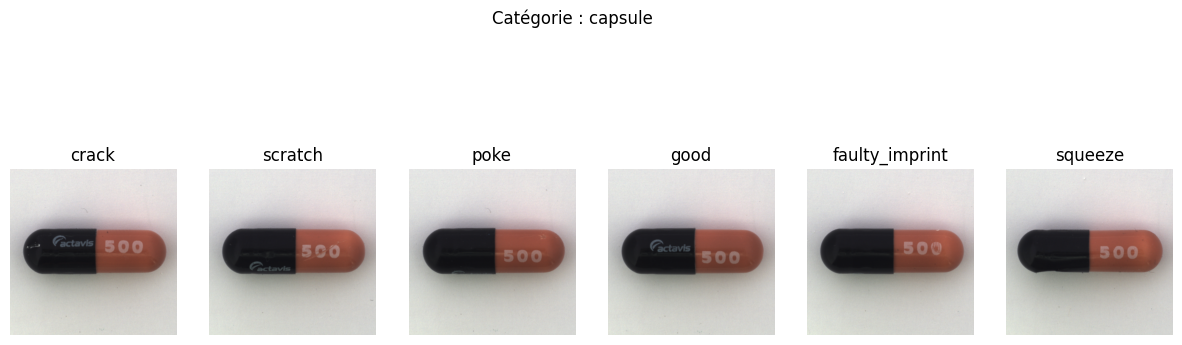

Catégorie : hazelnut
  MSE moyenne pour l'anomalie crack : 247.64
  MSE moyenne pour l'anomalie print : 514.72
  MSE moyenne pour l'anomalie good : 202.17
  MSE moyenne pour l'anomalie cut : 238.68
  MSE moyenne pour l'anomalie hole : 212.20


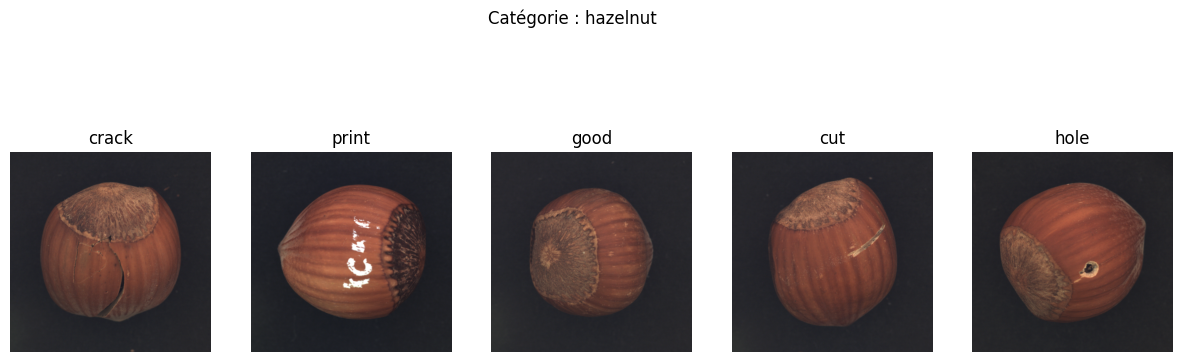

Catégorie : engine_wiring
  MSE moyenne pour l'anomalie fastening : 3335.79
  MSE moyenne pour l'anomalie multiple : 5061.35
  MSE moyenne pour l'anomalie cardboard : 21525.07
  MSE moyenne pour l'anomalie blue_hoop : 3884.03
  MSE moyenne pour l'anomalie good : 3452.24
  MSE moyenne pour l'anomalie obstruction : 5172.66


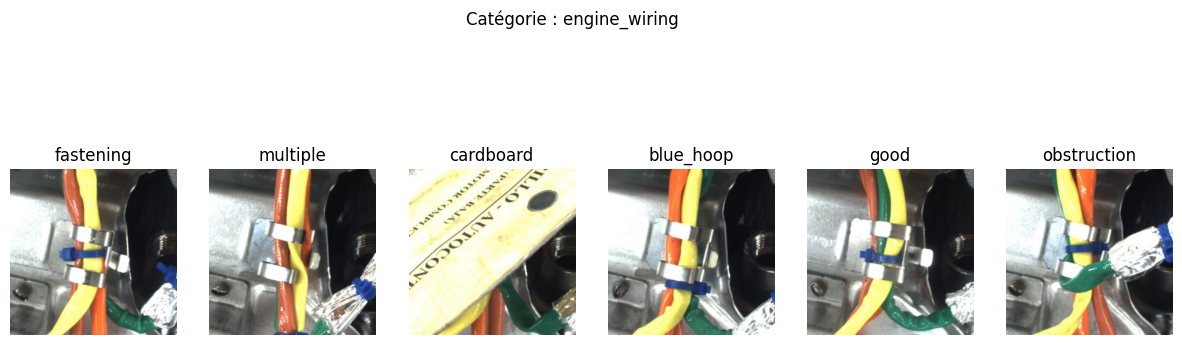

Catégorie : toothbrush
  MSE moyenne pour l'anomalie defective : 421.52
  MSE moyenne pour l'anomalie good : 213.50


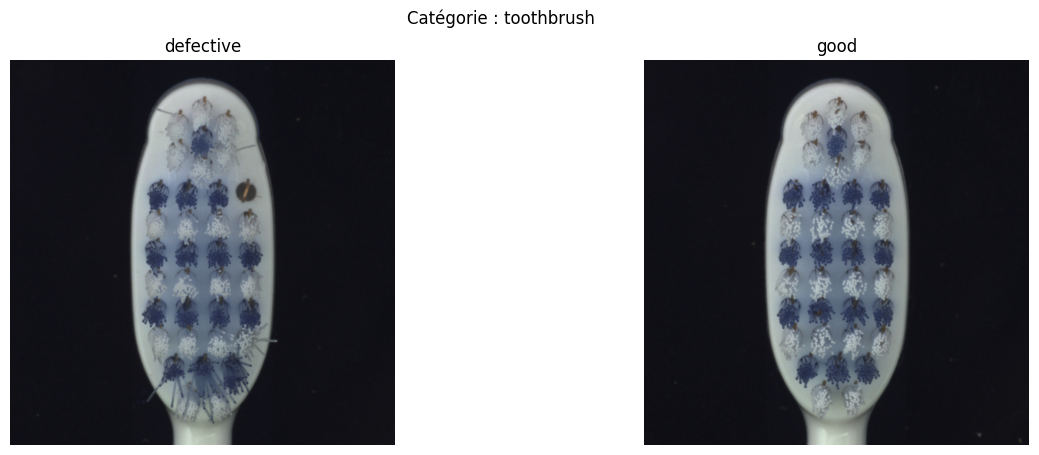

Catégorie : bottle
  MSE moyenne pour l'anomalie broken_small : 391.09
  MSE moyenne pour l'anomalie broken_large : 436.08
  MSE moyenne pour l'anomalie good : 242.99
  MSE moyenne pour l'anomalie contamination : 545.82


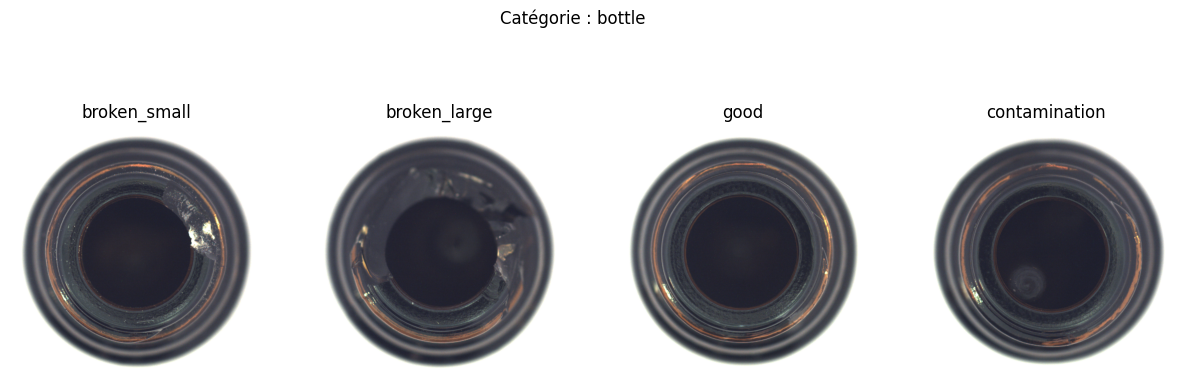

In [ ]:
display_anomalies("data/")

#

On ne capture surement pas assez les details fins \
Architecture plus sensible --> Unet avec des filtres de taille plus petite --> 3x3
Adapter la taille des mask en fonction des catégories : toothbrush et capsule --> petits \
                                                        bottle --> moyens \
                                                        engine et hazelnuth --> plus grand ou ne pas les changer étants donnés les résultats actuels \
Pour les catégories complexes (toothbrush, capsule, bottle) --> abaisser le learning rate

# Architecture Unet et adaptation des pretext aux catégories

## Architecture Unet

In [ ]:
def double_conv(in_channels, out_channels):
    # returns a block compsed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x)
        x = self.maxpool(x_skip)

        return x , x_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)

        return x


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.downsample_block_1 = DownSampleBlock(in_channels, 64)
        self.downsample_block_2 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)


        self.upsample_block_2 = UpSampleBlock(128 + 256, 128)
        self.upsample_block_1 = UpSampleBlock(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, out_channels, 1)


    def forward(self, x):
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)

        x = self.middle_conv_block(x)

        x = self.upsample_block_2(x, x_skip2)
        x = self.upsample_block_1(x, x_skip1)

        out = self.last_conv(x)

        return out

## Pretext

In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.Model = UNet(in_channels=1, out_channels=3)

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        x_hat = self.Model(grayscale_x)
        return x_hat, grayscale_x



class InpaintingModel(nn.Module):
    def __init__(self, mask_size=64, category="bottle"):
        super(InpaintingModel, self).__init__()
        self.Model = UNet()
        self.mask_size = mask_size
        self.category = category

    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            if self.category == "bottle":
                ul_x = np.random.randint(10, x.size(2) - self.mask_size + 1 -10)
                ul_y = np.random.randint(10, x.size(3) - self.mask_size + 1 - 10)
            elif self.category == "capsule":
                ul_x = np.random.randint(90, 160)
                ul_y = np.random.randint(15, x.size(3) - self.mask_size + 1 -15)
            elif self.category == "hazelnut":
                ul_x = np.random.randint(25, x.size(2) - self.mask_size + 1 -25)
                ul_y = np.random.randint(25, x.size(3) - self.mask_size + 1 -25)
            elif self.category == "toothbrush":
                ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
                ul_y = np.random.randint(90, 160)
            elif self.category == "engine_wiring":
                ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
                ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)

            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked




class MaskedAutoencoderModel(nn.Module):
    def __init__(self, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.Model = UNet()
        self.mask_ratio = mask_ratio

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked

## Inspection des tailles de masque

In [ ]:
def create_test_batch(data_dirs, transform, device='cpu'):
    """
    Crée un mini-batch de test contenant une image "good" par catégorie.

    Args:
        data_dir (str): Chemin vers le répertoire contenant les données.
        categories (list): Liste des noms des catégories (ex. ['capsule', 'hazelnuts']).
        transform (torchvision.transforms.Compose): Transformations à appliquer aux images.
        device (str): Appareil sur lequel charger les données ('cpu' ou 'cuda').

    Returns:
        torch.Tensor: Batch d'images (Tensor de taille (batch_size, channels, H, W)).
    """
    images = []
    for category, good_dir in data_dirs.items():
        # Liste des images dans le répertoire "good"
        image_files = [f for f in os.listdir(good_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            raise FileNotFoundError(f"Aucune image trouvée dans {good_dir}")

        # Charger la première image "good" trouvée
        image_path = os.path.join(good_dir, image_files[0])
        image = Image.open(image_path).convert('RGB')
        image = transform(image)  # Appliquer les transformations
        images.append(image)

    # Empiler les images pour créer un batch
    batch = torch.stack(images).to(device)
    return batch


# Transformations pour les images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),         # Convertir en tensor PyTorch
])

# Dossier racine des données
data_dir_dict = {
    'bottle': 'data/bottle/train/good',
    'capsule': 'data/capsule/train/good',
    'hazelnut': 'data/hazelnut/train/good',
    'toothbrush': 'data/toothbrush/train/good',
    'engine_wiring': 'data/engine_wiring/train/good'
}

# Créer le batch de test
test_batch = create_test_batch(data_dir_dict, transform, device)

print(f"Batch size : {test_batch.shape}")  # Affiche la forme du batch


Batch size : torch.Size([5, 3, 256, 256])


In [ ]:
def test_MAE(x, mask_ratio):
        x_masked = x.clone()
        mask = torch.rand_like(x[0, :, :]) < mask_ratio
        mask = mask.unsqueeze(0).repeat(x.size(0), 1, 1)
        x_masked[mask] = 0
        return x_masked

def test_inpainting(x, mask_size, categorie):
        masked_x = x.clone()
        if categorie == "bottle":
                ul_x = np.random.randint(10, x.size(1) - mask_size + 1 -10)
                ul_y = np.random.randint(10, x.size(2) - mask_size + 1 - 10)
        elif categorie == "capsule":
                ul_y = np.random.randint(15, x.size(1) - mask_size + 1 -15)
                ul_x = np.random.randint(90, 160)
        elif categorie == "hazelnut":
                ul_x = np.random.randint(25, x.size(1) - mask_size + 1 -25)
                ul_y = np.random.randint(25, x.size(2) - mask_size + 1 -25)
        elif categorie == "toothbrush":
                ul_y = np.random.randint(90, 160)
                ul_x = np.random.randint(0, x.size(2) - mask_size + 1)
        elif categorie == "engine_wiring":
                ul_x = np.random.randint(0, x.size(1) - mask_size + 1)
                ul_y = np.random.randint(0, x.size(2) - mask_size + 1)
        masked_x[:, ul_x:ul_x+mask_size, ul_y:ul_y+mask_size] = 0

        return masked_x

In [ ]:
def visualize_masks(test_batch, mask_sizes, mask_ratios,category):
    """
    Test différentes tailles de masques (mask_size) pour InpaintingModel et
    ratios de masques (mask_ratio) pour MaskedAutoencoderModel, puis affiche les résultats.

    Args:
        x: Batch d'images d'entrée (Tensor PyTorch de taille (batch_size, channels, H, W)).
        mask_sizes: Liste des tailles de masques pour InpaintingModel.
        mask_ratios: Liste des ratios de masques pour MaskedAutoencoderModel.
    """

    fig, axes = plt.subplots(len(mask_sizes) + len(mask_ratios), 5, figsize=(10, 3 * (len(mask_sizes) + len(mask_ratios))))
    fig.tight_layout()

    # Tester différentes tailles de masques pour InpaintingModel
    for i, mask_size in enumerate(mask_sizes):
        ipm = InpaintingModel(mask_size=mask_size)
        for j, im in enumerate(test_batch):
            x_masked = ipm.apply_mask(im, category=category[j])

            # Afficher l'original, masqué et reconstruit
            axes[i, j].imshow(x_masked.permute(1, 2, 0).cpu().numpy())
            axes[i, j].set_title(f"{mask_size}")
            #axes[i, j].axis("off")

    # Tester différents ratios de masques pour MaskedAutoencoderModel
    for h, mask_ratio in enumerate(mask_ratios):
        for g, im in enumerate(test_batch):
            x_masked = test_MAE(im, mask_ratio=mask_ratio)
            # Afficher l'original, masqué et reconstruit
            axes[h+len(mask_sizes), g].imshow(x_masked.permute(1, 2, 0).cpu().numpy())
            axes[h+len(mask_sizes), g].set_title(f"{mask_ratio:.2f}")
            axes[h+len(mask_sizes), g].axis("off")

    plt.show()


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

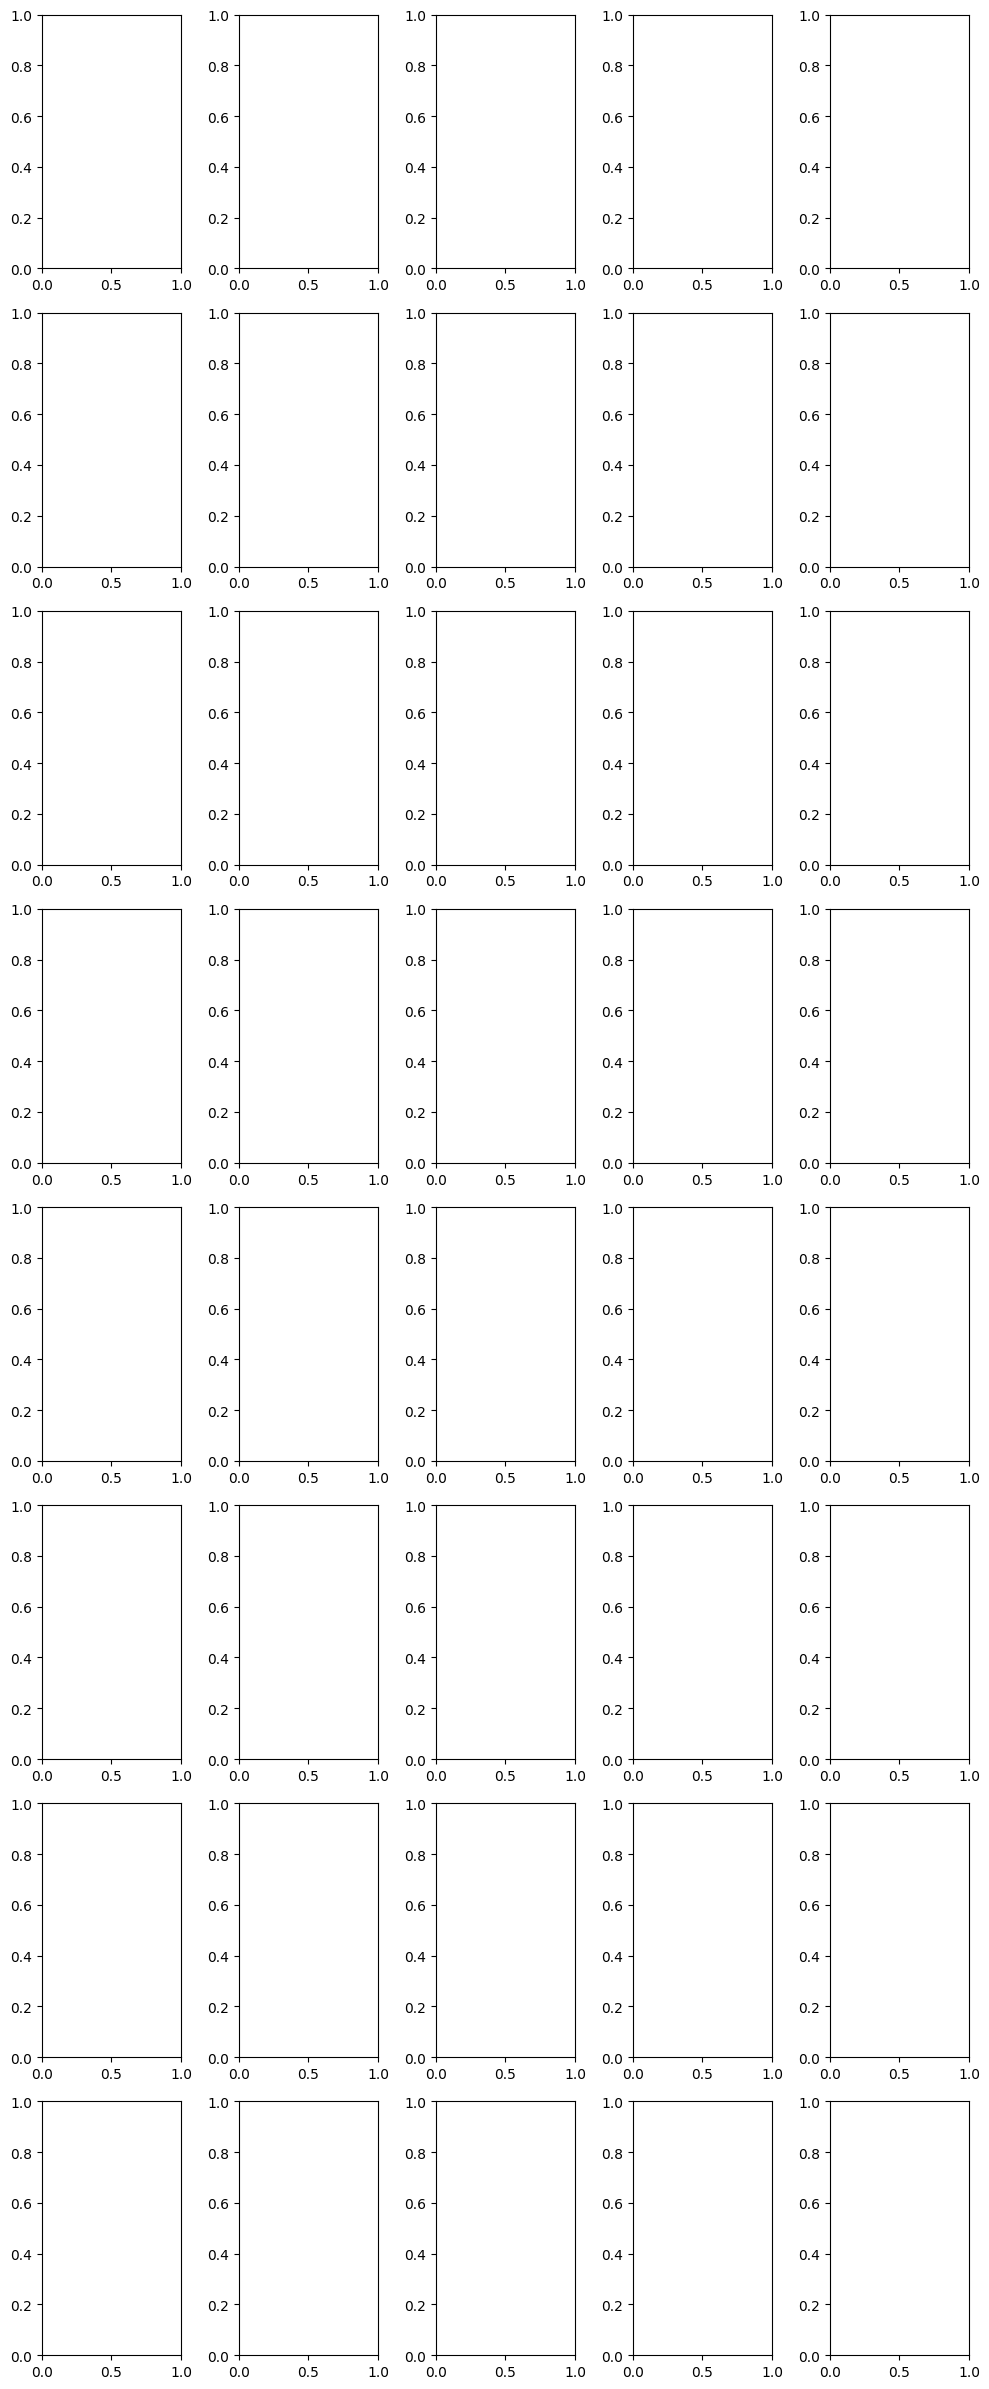

In [ ]:
mask_sizes = [16, 32, 64]
mask_ratios = [1/32, 1/16, 1/8, 1/4, 1/2]
category = ["bottle", "capsule", "hazelnut", "toothbrush", "engine_wiring"]
visualize_masks(test_batch, mask_sizes, mask_ratios, category)

## Pipeline d'entraînement et d'évaluation

In [ ]:

param_dict = {
    'bottle': {
        'mask_size': 64,
        'mask_ratio': 1/8,
        'lr' : 1e-3,
        'num_epochs' : 10
    },
    'capsule': {
        'mask_size': 16,
        'mask_ratio': 1/16,
        'lr' : 1e-4,
        'num_epochs' : 15
    },
    'hazelnut': {
        'mask_size': 64,
        'mask_ratio': 1/8,
        'lr' : 1e-3,
        'num_epochs' : 10
    },
    'toothbrush': {
        'mask_size': 16,
        'mask_ratio': 1/16,
        'lr' : 1e-4,
        'num_epochs' : 15
    },
    'engine_wiring': {
        'mask_size': 32,
        'mask_ratio': 1/16,
        'lr' : 1e-3,
        'num_epochs' : 10
    }
}

In [ ]:
def run_pipeline_multiple_pretexts(data_loaders_dict, param_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], device=device):

    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        mask_size = param_dict[category]['mask_size']
        mask_ratio = param_dict[category]['mask_ratio']
        lr = param_dict[category]['lr']
        num_epochs = param_dict[category]['num_epochs']

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel()
                criterion = nn.MSELoss(reduction="mean")   # on utilise la perte moyenne sur le batch pour stabiliser l'entrainement
            elif pretext == "inpainting":
                model = InpaintingModel(mask_size=mask_size)
                criterion = nn.MSELoss(reduction="mean")
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(mask_ratio=mask_ratio)
                criterion = nn.MSELoss(reduction="mean")

            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Entraîner le modèle
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]
            train_ssl_model(model, train_loader, test_loader, criterion, optimizer,
                                       device=device, epochs=num_epochs)

            # Sauvegarder le modèle
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(model, test_loader, criterion = nn.MSELoss(reduction="None"), pretext=pretext, device=device)
            # on utilise la perte par image pour différencier good de anomaly

            # Stocker les résultats
            category_results[pretext] = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results

In [ ]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline_multiple_pretexts(data_loaders_dict, param_dict=param_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"])

# Afficher les résultats
for category, pretext_results in results.items():
    for pretext, result in pretext_results.items():
        print(f"{category} - {pretext}: AUROC = {result['roc_auc']:.2f}")

=== Entraînement pour la catégorie bottle ===
Entraînement pour le prétexte : inpainting


# Test convolution attentionnelle

In [ ]:
# Define CutPaste augmentations
class CutPaste:
    def __init__(self, variant="normal"):
        self.variant = variant

    def __call__(self, img):
        w, h = img.size
        cut_w, cut_h = np.random.randint(w // 8, w // 4), np.random.randint(h // 8, h // 4)
        x, y = np.random.randint(0, w - cut_w), np.random.randint(0, h - cut_h)
        patch = img.crop((x, y, x + cut_w, y + cut_h))
        paste_x, paste_y = np.random.randint(0, w - cut_w), np.random.randint(0, h - cut_h)

        if self.variant == "scar":
            patch = patch.resize((cut_w // 2, cut_h * 2))

        img.paste(patch, (paste_x, paste_y))
        return img

In [ ]:
mean = pixel_stats["toothbrush"]["mean"]
std = pixel_stats["toothbrush"]["std"]


train_transforms = transforms.Compose([
    CutPaste(variant="normal"),  # Augmentation CutPaste
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalisation
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
class CategoryDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode="train"):
        self.root_dir = os.path.join(root_dir, mode)
        self.image_paths = []
        self.labels = []  # 0 = normal, 1 = anomalie

        self.transform = transform

        if mode == "train":
            normal_dir = os.path.join(self.root_dir, "good")
            self.image_paths += [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
            self.labels += [0] * len(self.image_paths)
        elif mode == "test":
            for defect_type in os.listdir(self.root_dir):
                defect_dir = os.path.join(self.root_dir, defect_type)
                self.image_paths += [os.path.join(defect_dir, f) for f in os.listdir(defect_dir)]
                self.labels += [0 if defect_type == "good" else 1] * len(os.listdir(defect_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Chargement des datasets
train_dataset = CategoryDataset(
    root_dir="data/toothbrush",
    transform=train_transforms,
    mode="train"
)

test_dataset = CategoryDataset(
    root_dir="data/toothbrush",
    transform=test_transforms,
    mode="test"
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06540787..1.2362145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06540787..1.2676256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077851176..1.3681412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08407289..1.3744233].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077851176..1.3241656].


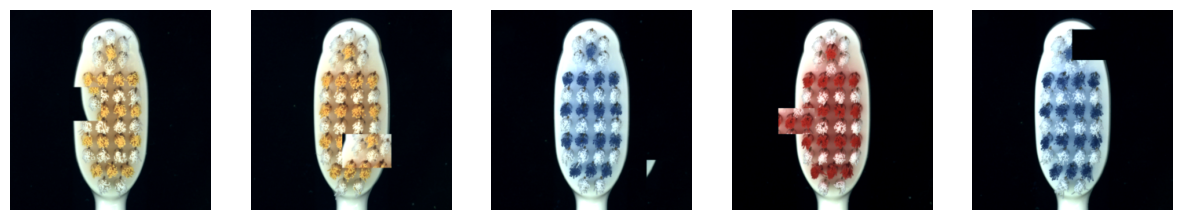

In [ ]:
# Exemple de visualisation
examples, _ = next(iter(train_loader))
examples = examples.permute(0, 2, 3, 1)  # Reformatage pour matplotlib
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(examples[i].numpy() * 0.5 + 0.5)  # Dé-normalisation
    axes[i].axis("off")
plt.show()

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class ChannelWiseTransformerBlock(nn.Module):
    def __init__(self, num_patches, patch_dim=1, dim=64, heads=5, dim_head=64, dropout=0.):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(patch_dim)
        self.projection = nn.Linear(patch_dim ** 2, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))

        self.mha = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.avg_pool(z)
        x = x.flatten(-2)

        x = self.projection(x)
        x += self.pos_embedding

        x = self.mha(x)
        x = x.mean(-1).unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)

        return z * x

# Define SSPCAB block
class SSPCAB(nn.Module):
    def __init__(self, channels, kernel_dim=1, dilation=1):
        super(SSPCAB, self).__init__()
        self.pad = kernel_dim + dilation
        self.border_input = kernel_dim + 2 * dilation + 1

        self.relu = nn.ReLU()
        self.transformer = ChannelWiseTransformerBlock(num_patches=channels, patch_dim=1)

        self.conv1 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv2 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv3 = nn.Conv2d(channels, channels, kernel_dim)
        self.conv4 = nn.Conv2d(channels, channels, kernel_dim)

    def forward(self, x_in):
        x = F.pad(x_in, (self.pad, self.pad, self.pad, self.pad), "constant", 0)

        x1 = self.conv1(x[:, :, :-self.border_input, :-self.border_input])
        x2 = self.conv2(x[:, :, self.border_input:, :-self.border_input])
        x3 = self.conv3(x[:, :, :-self.border_input, self.border_input:])
        x4 = self.conv4(x[:, :, self.border_input:, self.border_input:])
        x = self.relu(x1 + x2 + x3 + x4)

        x = self.transformer(x)

        # Calcul de la reconstruction erreur par image
        sspcab_loss = torch.mean((x - x_in) ** 2, dim=(1, 2, 3))
        return x, sspcab_loss  # Output and reconstruction loss

# Define the full model
class AnomalyDetectionModel(nn.Module):
    def __init__(self, in_channels):
        super(AnomalyDetectionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.sspcab = SSPCAB(128, kernel_dim=1, dilation=1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, in_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x_chap = self.encoder(x)
        x_chap, sspcab_loss = self.sspcab(x_chap)
        x_chap = self.decoder(x_chap)
        loss = torch.mean((x - x_chap) ** 2, dim=(1, 2, 3)) + sspcab_loss
        return x, loss

# Training function
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()

        recon, losses = model(imgs)
        loss = losses.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    anomaly_scores = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            outputs, losses = model(imgs)
            print(losses)
            loss = nn.MSELoss(outputs, images)  # Perte par pixel
            per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image

            anomaly_scores.extend(per_image_loss.cpu().numpy())
            labels.extend(lbls.numpy())  # Transforme les labels en liste plate

    return np.array(anomaly_scores), np.array(labels)

# Plot ROC curve
def plot_roc(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
model = AnomalyDetectionModel(in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

# Assuming data_loaders_dict contains dataloaders as in the provided code
#train_loader = data_loaders_dict['toothbrush']['train_loader']
#test_loader = data_loaders_dict['toothbrush']['test_loader']

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/10, Loss: 0.9137
Epoch 2/10, Loss: 0.9003
Epoch 3/10, Loss: 0.8936
Epoch 4/10, Loss: 0.8846
Epoch 5/10, Loss: 0.8778
Epoch 6/10, Loss: 0.8671
Epoch 7/10, Loss: 0.8622
Epoch 8/10, Loss: 0.8553
Epoch 9/10, Loss: 0.8496
Epoch 10/10, Loss: 0.8433


In [ ]:
scores, labels = evaluate(model, test_loader, device)
print(f"Scores shape: {scores.shape}, Labels shape: {labels.shape}")

tensor(0.8294)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

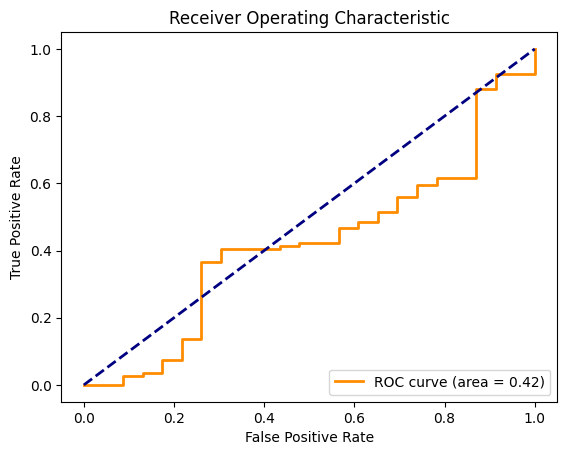

In [ ]:
plot_roc(labels, scores)